In [2]:
import os
from langchain.chat_models import init_chat_model
from getpass import getpass

In [3]:
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

In [4]:
llm = init_chat_model("openai:gpt-3.5-turbo", temperature=0.7)

In [5]:
os.environ["TAVILY_API_KEY"] = getpass("Enter yout Tavily API key: ")

In [6]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


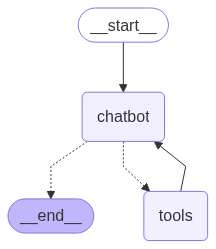

In [7]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Built berdasarkan tools (exercise sebelumnya)
- Chatbot sekarang udah bisa menggunakan tools untuk menjawab pertanyaan pengguna
- Tetapi dia tidak mengingat context dari interaksi sebelumnya, Hal in membatasi kemampuannya untuk melakukan multi-turn conversations yang koheren

## Langgraph memecahkan masalah ini melalui persistent checkpointing
- Jika checkpointer disediakan ketika mengcompile graph dan sebuah thread_id ketika calling graph
- LangGraph secara otomatis menyimpan state setelah setiap langkah
- Ketika grpah di-invoke lagi menggunakan thread_id yang sama, graf akan memuat state yang tersimpan, sehingga chatbot dapat melanjutkan dari titik terakhir

## Bagaimana Memory bekerja?
Buat MemorySaver checkpointer

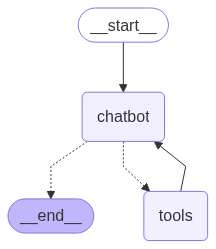

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Buat suatu thread untuk digunakan sebagai key untuk 1 conversation

In [11]:
config = {"configurable": {"thread_id": "1"}}

In [12]:
user_input = "Hello, my name is Rehun"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, my name is Rehun
================================== Ai Message ==================================

Hello Rehun! How can I assist you today?


## Follow up question

In [14]:
user_input = "remember my name?? who am i?"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

remember my name?? who am i?
================================== Ai Message ==================================

You are Rehun. How can I help you today, Rehun?


## Semisal kita mengganti thread_id

In [19]:
user_input = "remember my name?? who am i?"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

remember my name?? who am i?
================================== Ai Message ==================================

I'm sorry, but I don't have the ability to remember personal details about users. If there's anything specific you'd like to know or discuss, feel free to ask!


## Inspecting the State

In [20]:
snapshot = graph.get_state(config)

In [21]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hello, my name is Rehun', additional_kwargs={}, response_metadata={}, id='a0e2c257-84fd-4e68-b4e6-330f74796fe3'), AIMessage(content='Hello Rehun! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 815, 'total_tokens': 828, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BdPtZMLUVcNIn05j711xV7gRWtqLp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--93ebfb77-7f92-4cb9-875b-3ae3745e6283-0', usage_metadata={'input_tokens': 815, 'output_tokens': 13, 'total_tokens': 828, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

## FULL CODE

In [ ]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver() #tinggal nambahin ini aja, lalu set config diberikutnya
graph = graph_builder.compile(checkpointer=memory)

()